In [22]:
%reset -f

In [2]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import io  # for reading TIFF images
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from skimage import io  # for reading TIFF images
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K

In [3]:
# Set the desired number of patches
desired_num_patches = 7566

# Your data directories
dsm_images_dir = 'DSM_Clip_Patches'
solar_map_dir = 'Solar_Clip_Patches'

# Get the list of file names in the directories without sorting
dsm_files = os.listdir(dsm_images_dir)
solar_map_files = os.listdir(solar_map_dir)



In [4]:
# Initialize empty lists to store data
x_train_list = []
solar_values_list = []


# Loop through each patch with tqdm for progress bars
for i in tqdm(range(min(desired_num_patches, len(dsm_files))), desc='Loading Patches'):
    # Get file names for the current index
    dsm_file = dsm_files[i]
    solar_map_file = solar_map_files[i]
    
    # Load images
    dsm_image = io.imread(os.path.join(dsm_images_dir, dsm_file))
    solar_map = io.imread(os.path.join(solar_map_dir, solar_map_file))

    # Normalize the data using min-max scaling for DSM
    if np.min(dsm_image) != np.max(dsm_image):
        dsm_image_normalized = (dsm_image - np.min(dsm_image)) / (np.max(dsm_image) - np.min(dsm_image))
    else:
        dsm_image_normalized = dsm_image

    # Ensure the shape matches the specified format
    dsm_image_normalized = np.expand_dims(dsm_image_normalized, axis=-1)

    # Expand dimensions for solar map to match the channel dimension
    solar_map = np.expand_dims(solar_map, axis=-1)

    x_train_list.append(dsm_image_normalized)
    solar_values_list.append(solar_map)

    # Break the loop when desired_num_patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data_dsm = np.stack(x_train_list)
solar_values = np.stack(solar_values_list)

# Ensure the solar values have the correct shape
solar_values = np.squeeze(solar_values, axis=(3,))

# Normalize solar values using min-max scaling
min_solar = np.min(solar_values)
max_solar = np.max(solar_values)
solar_scaled = (solar_values - min_solar) / (max_solar - min_solar)

# Reshape scaled solar values for compatibility with the model
solar_normalized = np.expand_dims(solar_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_dsm, solar_normalized, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

# Print the shapes of the datasets
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

input_shape = x_train.shape[1:]


Loading Patches: 100%|█████████▉| 7565/7566 [00:43<00:00, 174.54it/s]


x_train: (4841, 128, 128, 1)
y_train: (4841, 128, 128, 1)
x_val shape: (1211, 128, 128, 1)
y_val shape: (1211, 128, 128, 1)
x_test shape: (1514, 128, 128, 1)
y_test shape: (1514, 128, 128, 1)


In [5]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

In [6]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  

In [7]:
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    
    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='nearest', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = Lambda(lambda x: K.tile(x, [1, 1, 1, shape_x[3]]))(upsample_psi)
    y = multiply([upsample_psi, x])

    return y


In [8]:
'''
  Attention U-Net model
'''

def UNetAM(trained_weights=None, input_size=(128, 128, 1), drop_rate=0.25, lr=0.0005, filter_base=16):
    # Input layer
    inputs = Input(input_size)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    # conv0 = Dropout(drop_rate)(conv0)

    # Modify the number of input channels to match your data
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    # conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    # conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    # conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate)  # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate)  # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate)  # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)  # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    # Modify the number of output channels to match your task
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss=mean_squared_error, metrics=[ 'mae'])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-3
    print('Learning rate: ', lr)
    return lr

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [9]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
# Train Attention U-Net with generator
checkpointer = tf.keras.callbacks.ModelCheckpoint('Solar-unet-attention-3d.hdf5',monitor='val_mae', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=300, monitor='val_mae'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]
model_attention_unet = UNetAM(lr=0.0001, filter_base=16)

# train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
import time

start_time = time.time()

# Your model training code here
results = model_attention_unet.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=300,callbacks=callbacks)

end_time = time.time()
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

print("Training completed in {:.2f} seconds ({:.2f} minutes)".format(training_time_seconds, training_time_minutes))

Epoch 1/300
152/152 [==============================] - ETA: 0s - loss: 0.0694 - mae: 0.2181
Epoch 1: val_mae improved from inf to 0.20051, saving model to Solar-unet-attention-3d.hdf5
152/152 [==============================] - 10s 43ms/step - loss: 0.0694 - mae: 0.2181 - val_loss: 0.0636 - val_mae: 0.2005
Epoch 2/300
151/152 [============================>.] - ETA: 0s - loss: 0.0582 - mae: 0.1886
Epoch 2: val_mae improved from 0.20051 to 0.19029, saving model to Solar-unet-attention-3d.hdf5
152/152 [==============================] - 6s 37ms/step - loss: 0.0582 - mae: 0.1885 - val_loss: 0.0599 - val_mae: 0.1903
Epoch 3/300
151/152 [============================>.] - ETA: 0s - loss: 0.0544 - mae: 0.1792
Epoch 3: val_mae improved from 0.19029 to 0.18187, saving model to Solar-unet-attention-3d.hdf5
152/152 [==============================] - 6s 37ms/step - loss: 0.0544 - mae: 0.1792 - val_loss: 0.0559 - val_mae: 0.1819
Epoch 4/300
152/152 [==============================] - ETA: 0s - loss: 0.

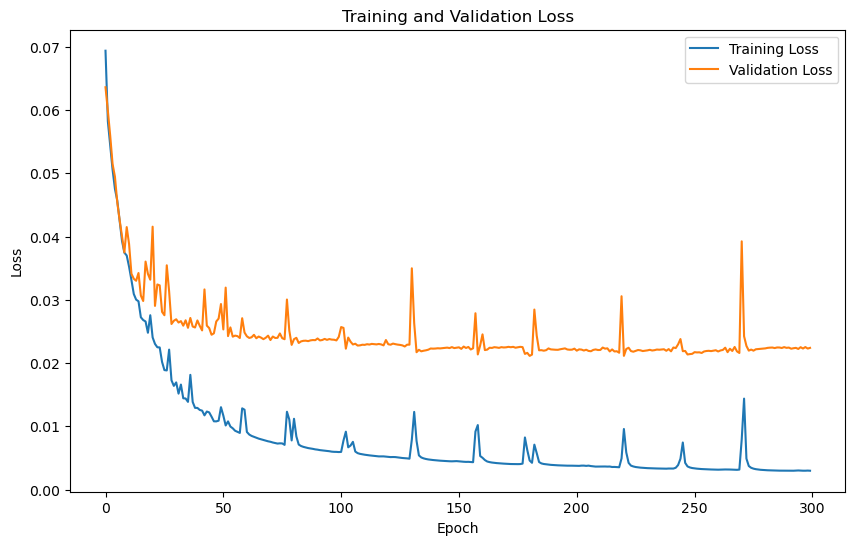

In [11]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()

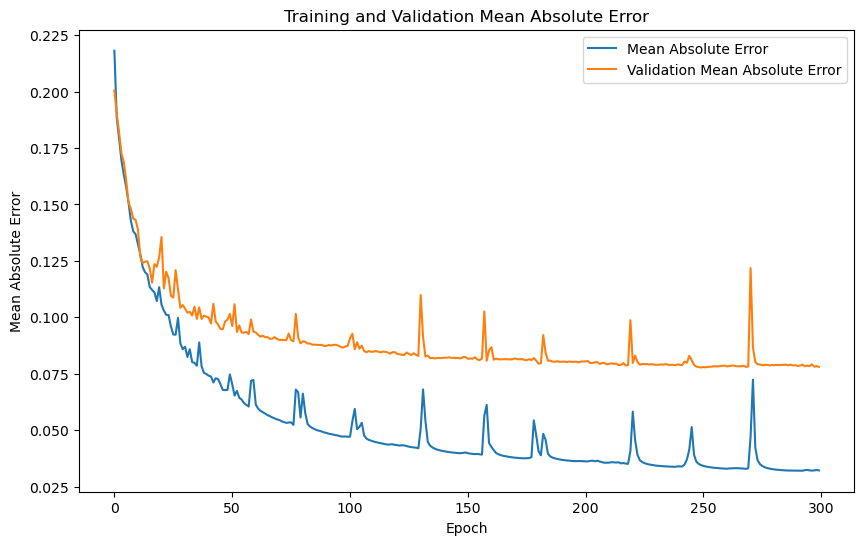

In [12]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['mae'], label='Mean Absolute Error')
plt.plot(results.history['val_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [17]:
solar_max = np.max(solar_values)
solar_min = np.min(solar_values)
print(solar_max)
print(solar_min)

1045434.44
0.0


In [13]:
start_time = time.time()
y_pred1 = model_attention_unet.predict(x_test)

end_time = time.time()
x_test_time_seconds = end_time - start_time
x_test_time_minutes = x_test_time_seconds / 60

print("x_test_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_test_time_seconds, x_test_time_minutes))

48/48 [==============================] - 1s 17ms/step
x_test_Prediction completed in 1.13 seconds (0.02 minutes)


In [18]:
y_pred1 = model_attention_unet.predict(x_test)
y_pred = y_pred1 * (solar_max - solar_min) + solar_min
y_test2 = y_test * (solar_max - solar_min) + solar_min


48/48 [==============================] - 1s 8ms/step


In [19]:
# Flatten the arrays
y_test2_flat = y_test2.flatten()
y_pred_flat = y_pred.flatten()

# Calculate R^2
r2 = r2_score(y_test2_flat, y_pred_flat)

In [14]:

start_time = time.time()
y_train_pred =  model_attention_unet.predict(x_train)

end_time = time.time()
x_train_time_seconds = end_time - start_time
x_train_time_minutes = x_train_time_seconds / 60

print("x_train_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_train_time_seconds,x_train_time_minutes))

152/152 [==============================] - 1s 8ms/step
x_train_Prediction completed in 1.72 seconds (0.03 minutes)


In [15]:

start_time = time.time()
y_train_pred =  model_attention_unet.predict(x_data_dsm)

end_time = time.time()
x_data_dsm_time_seconds = end_time - start_time
x_data_dsm_time_minutes = x_data_dsm_time_seconds / 60

print("x_data_dsm_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_data_dsm_time_seconds,x_data_dsm_time_minutes))

237/237 [==============================] - 2s 9ms/step
x_data_dsm_Prediction completed in 2.77 seconds (0.05 minutes)


In [20]:
# Calculate R^2 for training data
y_train_pred = model_attention_unet.predict(x_train)
y_train_pred2 = y_train_pred * (solar_max - solar_min) + solar_min
y_train2 = y_train * (solar_max - solar_min) + solar_min
# # Flatten the arrays
y_train_pred2_flat = y_train_pred2.flatten()
y_train2_flat = y_train2.flatten()

# Calculate R^2 for training data
r2_train = r2_score(y_train2_flat, y_train_pred2_flat)


152/152 [==============================] - 1s 9ms/step


C:\Users\Green\AppData\Local\Temp\ipykernel_1416\4216629586.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=300, bbox_inches='tight')
c:\Users\Green\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


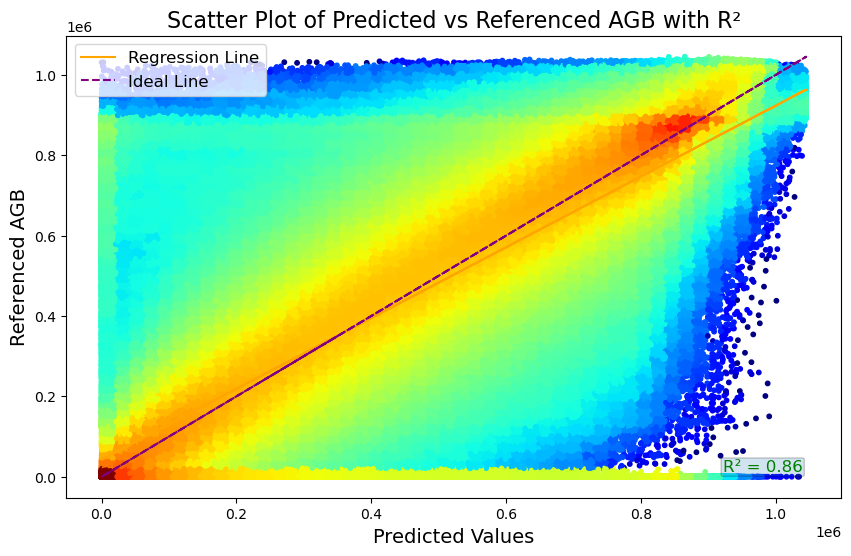

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Reshape arrays if needed
y_test2 = y_test2_flat
y_pred = y_pred_flat

# Create a figure and axis with a larger size
plt.figure(figsize=(10, 6))

# Create a 2D histogram to calculate point density
hist, x_edges, y_edges = np.histogram2d(y_test2, y_pred, bins=(50, 50), density=True)

# Calculate the point density for each point
density = hist[np.clip(np.digitize(y_test2, x_edges) - 1, 0, hist.shape[0] - 1),
               np.clip(np.digitize(y_pred, y_edges) - 1, 0, hist.shape[1] - 1)]

# Use logarithmic scaling for density values
log_density = np.log1p(density)

# Scatter plot with color based on log-scaled density and inverse hot colormap
scatter = plt.scatter(y_pred, y_test2, c=log_density, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)
plt.plot(y_test2, poly_y, color='orange', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Add labels, legend, and colorbar with larger font sizes
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Referenced AGB', fontsize=14)
plt.title('Scatter Plot of Predicted vs Referenced AGB with R²', fontsize=16)
plt.legend(fontsize=12)

# Annotate R^2 value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=12, ha='right', va='bottom', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Save the plot as a high-quality PNG image with larger font sizes
plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
